In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm

import pandas as pd
data = pd.read_csv('hiv_protease_inhibitors_data_chemlb_full.csv')

smiles = list(data['canonical_smiles'])
#smiles

text = " ".join(smiles)
chars = sorted(list(set(text)))
vocab_size = len(chars)


stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])


"\nstoi = {ch: i for i, ch in enumerate(chars)}\nitos = {i: ch for i, ch in enumerate(chars)}\nencode = lambda s: [stoi[c] for c in s]\ndecode = lambda l: ''.join([itos[i] for i in l])\n"

In [39]:
print(smiles[0])

CC(C)CN(Sc1ccc2c(c1)CCO2)[C@H](CO)CCCCNC(=O)[C@@H](Cc1cccc2ccccc12)NC(=O)N1CCOCC1


In [48]:
#separete a string  into sections with valid parenthesis or brackets

def separate(s):
    stack = []
    sections = []
    for i, c in enumerate(s):
        if c in ['(', '[']:
            stack.append((c, i))
        elif c in [')', ']']:
            while stack:
                opening, start = stack[-1]  # Peek at the top of the stack
                if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                    stack.pop()  # Remove the matching opening bracket
                    sections.append((start, i))
                    break
                else:
                    stack.pop()  # Remove the non-matching opening bracket

    # Filter out overlapping sections
    non_overlapping_sections = []
    last_end = -1
    for start, end in sorted(sections, key=lambda x: x[0]):
        if start > last_end:
            non_overlapping_sections.append((start, end))
            last_end = end

    return non_overlapping_sections


def show_sections(s, sections):
    all_sections = []
    last_end = 0  # To keep track of the last section's end index

    for start, end in sections:
        if start > last_end:
            # Add the section between the last end and this start
            all_sections.append(s[last_end:start])
        # Add the section within the current parenthesis/bracket
        all_sections.append(s[start:end+1])
        last_end = end + 1  # Update the last end index

    # Handle any remaining section after the last parenthesis/bracket
    if last_end < len(s):
        all_sections.append(s[last_end:])

    return all_sections

s = smiles[0]
sections = separate(s)
all_sections = show_sections(s, sections)
" ".join(all_sections)
    




'CC (C) CN (Sc1ccc2c(c1)CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1'

In [64]:
text = ""

for s in smiles:
    sections = separate(s)
    all_sections = show_sections(s, sections)
    text += " ".join(all_sections)
    text += "*"

In [65]:
text

'CC (C) CN (Sc1ccc2c(c1)CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1*CC (C) CN (Sc1ccc2c(c1)OCCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1*CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)N1CCOCC1) S (=O) (=O) c1ccc2c (c1) CCO2*Cc1c (O) cccc1C (=O) N [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)c1cccc(=O)[nH]1) S (=O) (=O) c1ccc (N) cc1*Cc1ccccc1C [C@H] (NC(=O)c1cccnc1) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*O=C (O) CNC (=O) c1c (=O) oc (O) c2cc (Br) ccc12*C [C@H] (NC(=O)c1c(=O)oc(O)c2cccc(-c3cccc(C(F)(F)F)c3)c12) C (=O) O*Cc1ccccc1C [C@H] (NC(=O)c1cccc(C)c1O) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*COC (=O) N [C@@H] (CC1CCCCC1) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](CC1CCCCC1)NC(=O)c1cccnc1) S (=O) (=O) c1ccc (N) cc1*Cc1ccc (C(=O)N[C@@H]

In [66]:
chars = sorted(list(set(text)))
vocab_size = len(chars)


stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])


In [67]:
vocab_size

25

In [68]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

tensor([10, 10,  1,  ..., 18, 18,  4])

In [69]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 500
eval_interval = 10
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 25
n_head = 5
n_layer = 6
dropout = 0.0

In [70]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [71]:
class SMILESTransformer(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, dropout):
        super(SMILESTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.transformer = nn.Transformer(n_embd, n_head, n_layer, dropout=dropout)
        self.fc = nn.Linear(n_embd, vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = self.fc(x)
        x = self.log_softmax(x) 
        return x
    
    def generate(self, idx, max_new_tokens, block_size):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx
    

model = SMILESTransformer(vocab_size, n_embd, n_head, n_layer, dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
def estimate_loss():
    losses = {}
    for split in ['train', 'val']:
        x, y = get_batch(split)
        output = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        losses[split] = loss.item()
    return losses

In [73]:
for iter in tqdm(range(max_iters)):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    output = model(xb)
    loss = criterion(output.view(-1, vocab_size), yb.view(-1))

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

step 0: train loss 3.1839, val loss 3.1272


  2%|▏         | 10/500 [00:02<02:01,  4.03it/s]

step 10: train loss 2.7049, val loss 2.6784


  4%|▍         | 20/500 [00:05<02:01,  3.94it/s]

step 20: train loss 2.6624, val loss 2.6497


  6%|▌         | 30/500 [00:08<01:55,  4.09it/s]

step 30: train loss 2.5833, val loss 2.5562


  8%|▊         | 40/500 [00:10<01:47,  4.29it/s]

step 40: train loss 2.5420, val loss 2.4835


 10%|█         | 50/500 [00:13<01:45,  4.27it/s]

step 50: train loss 2.5233, val loss 2.4582


 12%|█▏        | 60/500 [00:15<01:40,  4.36it/s]

step 60: train loss 2.4745, val loss 2.4955


 14%|█▍        | 70/500 [00:18<01:47,  3.99it/s]

step 70: train loss 2.5236, val loss 2.4567


 16%|█▌        | 80/500 [00:20<01:38,  4.28it/s]

step 80: train loss 2.5188, val loss 2.4797


 18%|█▊        | 90/500 [00:23<01:35,  4.31it/s]

step 90: train loss 2.4894, val loss 2.5378


 20%|██        | 100/500 [00:25<01:33,  4.26it/s]

step 100: train loss 2.3853, val loss 2.3004


 22%|██▏       | 110/500 [00:28<01:31,  4.24it/s]

step 110: train loss 2.0373, val loss 1.9775


 24%|██▍       | 120/500 [00:30<01:30,  4.22it/s]

step 120: train loss 1.7490, val loss 1.7719


 26%|██▌       | 130/500 [00:33<01:29,  4.12it/s]

step 130: train loss 1.6053, val loss 1.6862


 28%|██▊       | 140/500 [00:36<01:26,  4.18it/s]

step 140: train loss 1.4933, val loss 1.6384


 30%|███       | 150/500 [00:38<01:27,  3.99it/s]

step 150: train loss 1.5133, val loss 1.5447


 32%|███▏      | 160/500 [00:41<01:24,  4.04it/s]

step 160: train loss 1.4973, val loss 1.4941


 34%|███▍      | 170/500 [00:43<01:21,  4.06it/s]

step 170: train loss 1.4381, val loss 1.7087


 36%|███▌      | 180/500 [00:46<01:22,  3.90it/s]

step 180: train loss 1.4703, val loss 1.4315


 38%|███▊      | 190/500 [00:49<01:16,  4.04it/s]

step 190: train loss 1.3867, val loss 1.3467


 40%|████      | 200/500 [00:52<01:21,  3.70it/s]

step 200: train loss 1.4353, val loss 1.4417


 42%|████▏     | 210/500 [00:55<01:21,  3.55it/s]

step 210: train loss 1.4929, val loss 1.5582


 44%|████▍     | 220/500 [00:57<01:08,  4.12it/s]

step 220: train loss 1.4241, val loss 1.7393


 46%|████▌     | 230/500 [01:00<01:11,  3.78it/s]

step 230: train loss 1.4000, val loss 1.3762


 48%|████▊     | 240/500 [01:03<01:02,  4.14it/s]

step 240: train loss 1.3503, val loss 1.4091


 50%|█████     | 250/500 [01:05<00:57,  4.35it/s]

step 250: train loss 1.3450, val loss 1.3789


 52%|█████▏    | 260/500 [01:08<00:58,  4.13it/s]

step 260: train loss 1.4279, val loss 1.2266


 54%|█████▍    | 270/500 [01:11<01:00,  3.78it/s]

step 270: train loss 1.2958, val loss 1.3409


 56%|█████▌    | 280/500 [01:13<00:55,  3.94it/s]

step 280: train loss 1.3467, val loss 1.4682


 58%|█████▊    | 290/500 [01:16<00:51,  4.05it/s]

step 290: train loss 1.3709, val loss 1.4261


 60%|██████    | 300/500 [01:19<00:54,  3.64it/s]

step 300: train loss 1.4625, val loss 1.5101


 62%|██████▏   | 310/500 [01:22<00:51,  3.69it/s]

step 310: train loss 1.2201, val loss 1.2456


 64%|██████▍   | 320/500 [01:25<00:49,  3.65it/s]

step 320: train loss 1.2856, val loss 1.3695


 66%|██████▌   | 330/500 [01:28<00:51,  3.31it/s]

step 330: train loss 1.3889, val loss 1.3995


 68%|██████▊   | 340/500 [01:31<00:41,  3.89it/s]

step 340: train loss 1.3119, val loss 1.3554


 70%|███████   | 350/500 [01:33<00:39,  3.82it/s]

step 350: train loss 1.3419, val loss 1.4947


 72%|███████▏  | 360/500 [01:36<00:39,  3.57it/s]

step 360: train loss 1.4296, val loss 1.5031


 74%|███████▍  | 370/500 [01:39<00:33,  3.91it/s]

step 370: train loss 1.3687, val loss 1.4344


 76%|███████▌  | 380/500 [01:42<00:30,  3.99it/s]

step 380: train loss 1.2812, val loss 1.5541


 78%|███████▊  | 390/500 [01:45<00:28,  3.90it/s]

step 390: train loss 1.3938, val loss 1.4578


 80%|████████  | 400/500 [01:47<00:25,  3.91it/s]

step 400: train loss 1.3038, val loss 1.5541


 82%|████████▏ | 410/500 [01:50<00:23,  3.84it/s]

step 410: train loss 1.3716, val loss 1.4596


 84%|████████▍ | 420/500 [01:53<00:18,  4.39it/s]

step 420: train loss 1.3856, val loss 1.3828


 86%|████████▌ | 430/500 [01:55<00:15,  4.49it/s]

step 430: train loss 1.3847, val loss 1.4246


 88%|████████▊ | 440/500 [01:57<00:14,  4.12it/s]

step 440: train loss 1.3183, val loss 1.3955


 90%|█████████ | 450/500 [02:00<00:12,  3.92it/s]

step 450: train loss 1.2984, val loss 1.5664


 92%|█████████▏| 460/500 [02:03<00:09,  4.05it/s]

step 460: train loss 1.3368, val loss 1.3275


 94%|█████████▍| 470/500 [02:06<00:07,  4.15it/s]

step 470: train loss 1.3594, val loss 1.3879


 96%|█████████▌| 480/500 [02:08<00:04,  4.14it/s]

step 480: train loss 1.3067, val loss 1.4637


 98%|█████████▊| 490/500 [02:11<00:02,  4.45it/s]

step 490: train loss 1.3298, val loss 1.4253


100%|█████████▉| 499/500 [02:13<00:00,  4.02it/s]

step 499: train loss 1.4188, val loss 1.3759


100%|██████████| 500/500 [02:13<00:00,  3.73it/s]


In [60]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_sequence = model.generate(context, max_new_tokens=500, block_size=block_size)
sequence = decode(generated_sequence[0].tolist())

In [61]:
sequence = sequence.split(' ')
sequence

['',
 'CC@H](=SH](C',
 'S)',
 'S([(c1c1ccc1cc1C)',
 '([l)',
 'C@@@H]([)((=O)(C(=O@H](=O)C',
 '(=O)O@@H](COC(N',
 '(CCCcc1ccc1',
 'c1C@l)N',
 '(=O)C',
 '(S(]([C)',
 '[C-c1c1BnCCCCCO)',
 '(C1C',
 'CC[)C',
 '[CC)(C',
 '(NCCO)',
 '(CO)',
 '(=OCCC[Ccc(c1ccc2c1ccc2ccccl)',
 '(=NCCcc=O)',
 '(CC(NCNCC(',
 '(=O)SC)',
 'CCC@H](=OCO)',
 'CNCC@(=NC',
 'c',
 'c',
 '(ccc',
 'CCcc(CO)NC',
 '((c2c1',
 'CCC',
 '(c(c1cccc)1cccccc1)CC(c1c1cc1c',
 '(=BCN',
 'ccccn1c1c1C',
 'S',
 '(NCO)N',
 'N)r1)',
 'CO)r([)cccc)(CC',
 '@H](=O)',
 '(C@H](=OC',
 '(=O)',
 '(c1)',
 '(cccc([Cc2',
 '(=O)',
 '(cc1cccc1)',
 '(N)cccccc1',
 's)',
 'NC',
 '(ccc',
 'S)',
 'cccc',
 '(=O)cc(CC)([CCO)',
 '(C2c',
 'NNCNN',
 'N(=OCC@H](S(CCO)11',
 'CC',
 'ccc1c1']

In [62]:
sequence = [s for s in sequence if len(s) > 2]
sequence

['CC@H](=SH](C',
 'S([(c1c1ccc1cc1C)',
 '([l)',
 'C@@@H]([)((=O)(C(=O@H](=O)C',
 '(=O)O@@H](COC(N',
 '(CCCcc1ccc1',
 'c1C@l)N',
 '(=O)C',
 '(S(]([C)',
 '[C-c1c1BnCCCCCO)',
 '(C1C',
 'CC[)C',
 '[CC)(C',
 '(NCCO)',
 '(CO)',
 '(=OCCC[Ccc(c1ccc2c1ccc2ccccl)',
 '(=NCCcc=O)',
 '(CC(NCNCC(',
 '(=O)SC)',
 'CCC@H](=OCO)',
 'CNCC@(=NC',
 '(ccc',
 'CCcc(CO)NC',
 '((c2c1',
 'CCC',
 '(c(c1cccc)1cccccc1)CC(c1c1cc1c',
 '(=BCN',
 'ccccn1c1c1C',
 '(NCO)N',
 'N)r1)',
 'CO)r([)cccc)(CC',
 '@H](=O)',
 '(C@H](=OC',
 '(=O)',
 '(c1)',
 '(cccc([Cc2',
 '(=O)',
 '(cc1cccc1)',
 '(N)cccccc1',
 '(ccc',
 'cccc',
 '(=O)cc(CC)([CCO)',
 '(C2c',
 'NNCNN',
 'N(=OCC@H](S(CCO)11',
 'ccc1c1']

[03:36:58] SMILES Parse Error: syntax error while parsing: CC@H](=SH](C
[03:36:58] SMILES Parse Error: Failed parsing SMILES 'CC@H](=SH](C' for input: 'CC@H](=SH](C'
[03:36:58] SMILES Parse Error: syntax error while parsing: S([(c1c1ccc1cc1C)
[03:36:58] SMILES Parse Error: Failed parsing SMILES 'S([(c1c1ccc1cc1C)' for input: 'S([(c1c1ccc1cc1C)'
[03:36:58] SMILES Parse Error: syntax error while parsing: ([l)
[03:36:58] SMILES Parse Error: Failed parsing SMILES '([l)' for input: '([l)'
[03:36:58] SMILES Parse Error: syntax error while parsing: C@@@H]([)((=O)(C(=O@H](=O)C
[03:36:58] SMILES Parse Error: Failed parsing SMILES 'C@@@H]([)((=O)(C(=O@H](=O)C' for input: 'C@@@H]([)((=O)(C(=O@H](=O)C'
[03:36:58] SMILES Parse Error: syntax error while parsing: (=O)O@@H](COC(N
[03:36:58] SMILES Parse Error: Failed parsing SMILES '(=O)O@@H](COC(N' for input: '(=O)O@@H](COC(N'
[03:36:58] SMILES Parse Error: syntax error while parsing: (CCCcc1ccc1
[03:36:58] SMILES Parse Error: Failed parsing SMILES '

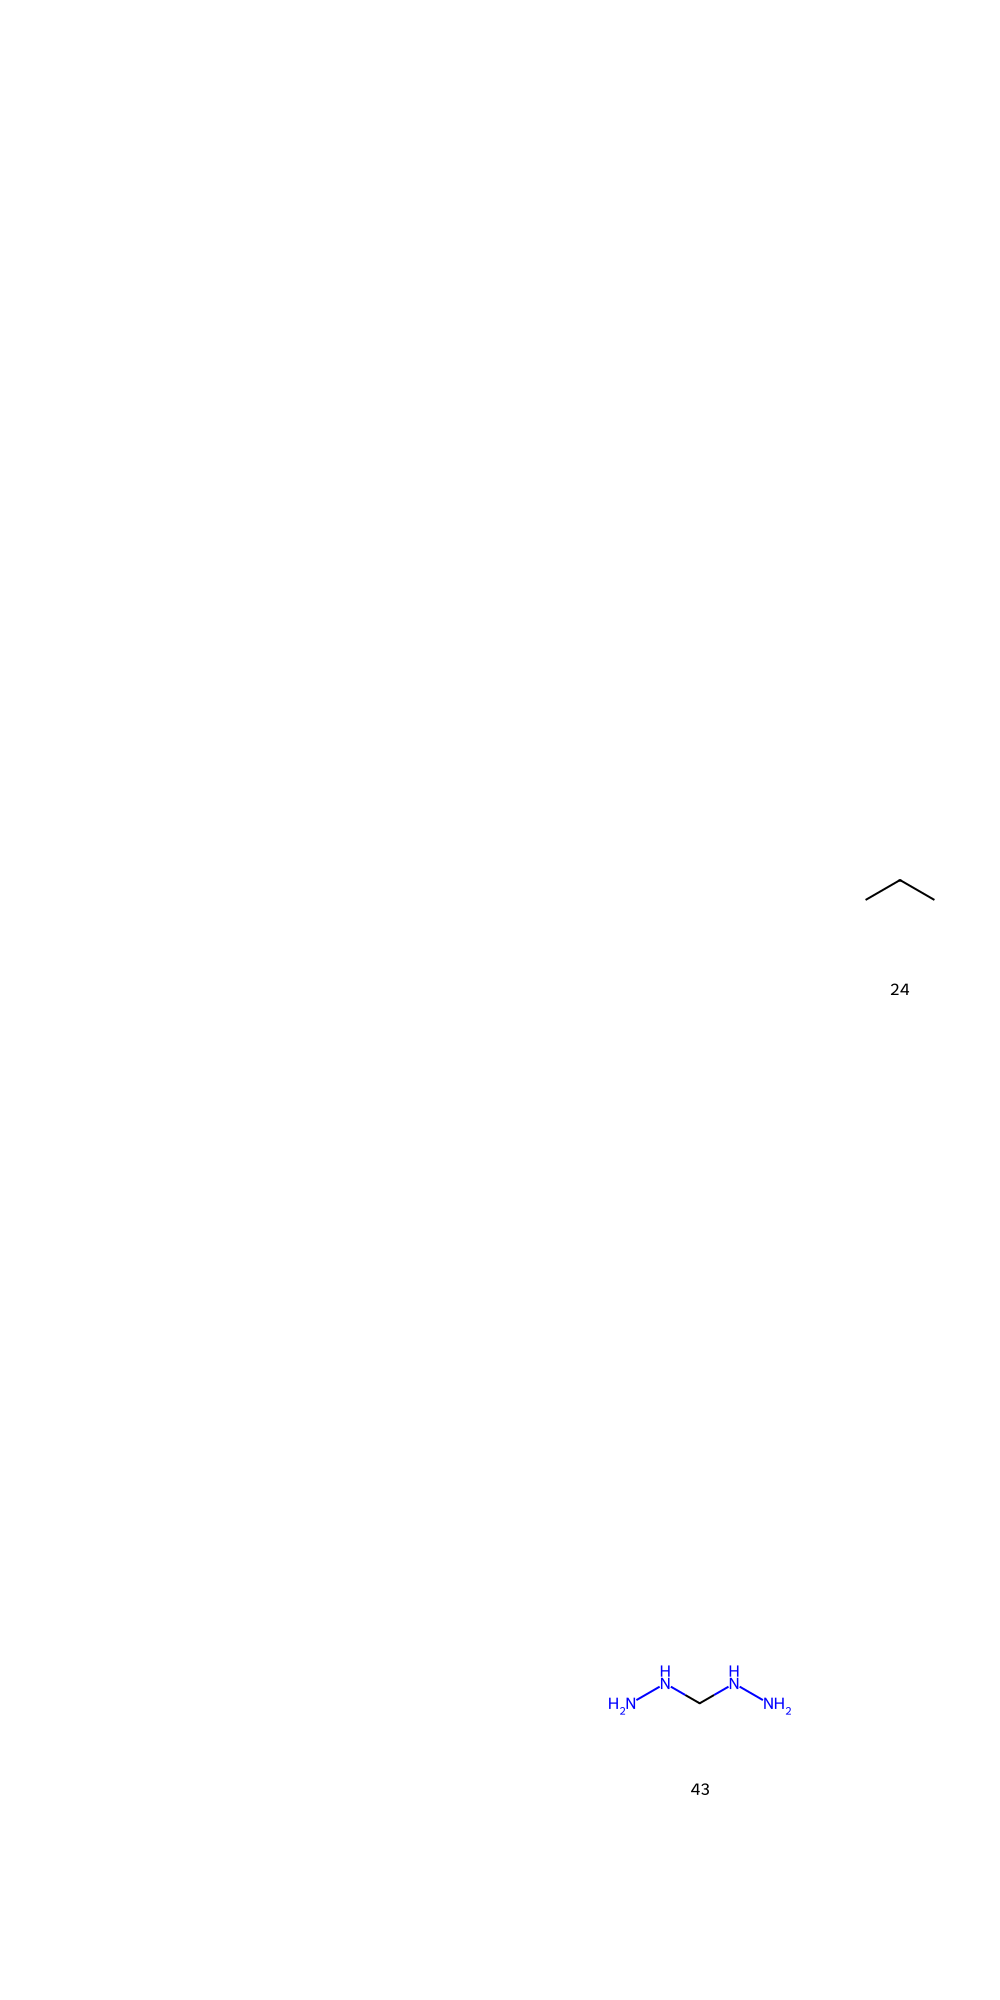

In [63]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mols = [Chem.MolFromSmiles(s) for s in sequence]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in range(len(mols))])